In [8]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import yahoo_finance as yf
import pandas_datareader as pdr
import statsmodels.api as sm
from datetime import date
from sklearn.cluster import KMeans
from statsmodels.tsa.api import adfuller
from sklearn.preprocessing import StandardScaler
from dateutil.relativedelta import relativedelta
from statsmodels.regression.rolling import RollingOLS

# Modify some settings
plt.rcParams['figure.figsize'] = (15, 7)
plt.rcParams['font.size'] = 16
plt.rcParams['figure.dpi'] = 150

pd.options.display.max_rows = 20
pd.options.display.max_columns = 15

import plotly.express as px
import plotly.graph_objects as go

In [9]:


class ChartBuilder(object):
    
    def __init__(self, s1, s2, start, end, exit=0, long_stop = -3, short_stop = 3, long_enter = -2, short_enter = 2):
        
        self.s1 = s1
        self.s2 = s2
        self.start = start
        self.end = end
        self.exit = exit
        self.long_stop = long_stop
        self.short_stop = short_stop
        self.long_enter = long_enter
        self.short_enter = short_enter
        
        self.pair = str("{} and {} ".format(self.s1, self.s2))
        self.scale = str(" ({} - {})".format(self.start, self.end))
        
# Customized Area chart

    def plot(self, signal_data, metric_data, metric, trades, add_signal_levels = True, add_trades = True):
        
        
        self.signal_data = signal_data
        self.metric_data = metric_data
        self.trades = trades
        self.data = pd.concat([self.signal_data, self.metric_data], axis = 1)
        self.metric = str(metric) 
        self.add_signal_levels = add_signal_levels
        self.add_trades = add_trades
        self.title = self.pair + self.metric + self.scale
        self.y0 = self.data[self.metric].max()
        self.y1 = self.data[self.metric].min()
        c_line = px.line(x = self.data.index, y = self.data[self.metric], title = self.title)

        c_line.update_xaxes(
            title_text = 'Date',
            rangeslider_visible = False,
            rangeselector = dict(
                buttons = list([
                    dict(count = 1, label = '1M', step = 'month', stepmode = 'backward'),
                    dict(count = 6, label = '6M', step = 'month', stepmode = 'backward'),
                    dict(count = 1, label = 'YTD', step = 'year', stepmode = 'todate'),
                    dict(count = 1, label = '1Y', step = 'year', stepmode = 'backward'),
                    dict(step = 'all')])))
        
        if self.add_signal_levels == True:
            if self.metric == 'Z_Score':
                c_line.add_shape(type = "line", x0 = self.start, x1 = self.end, y0 = self.exit, y1 = self.exit, line=dict(color = 'orange', width = 2, dash = 'dash'))
                c_line.add_shape(type = "line", x0 = self.start, x1 = self.end, y0 = self.short_stop, y1 = self.short_stop, line=dict(color = 'red', width = 2, dash = 'dash'))
                c_line.add_shape(type = "line", x0 = self.start, x1 = self.end, y0 = self.long_stop, y1 = self.long_stop, line=dict(color = 'red', width = 2, dash = 'dash'))
                c_line.add_shape(type = "line", x0 = self.start, x1 = self.end, y0 = self.long_enter, y1 = self.long_enter, line=dict(color = 'green', width = 2, dash = 'dash'))
                c_line.add_shape(type = "line", x0 = self.start, x1 = self.end, y0 = self.short_enter, y1 = self.short_enter, line=dict(color = 'green', width = 2, dash = 'dash'))
        
        if self.add_trades == True:
            
            for index, row in self.trades.iterrows():
                if self.trades.iloc[index]['Arb_Type'] == 'Short':
                    c_line.add_shape(type = 'rect', 
                                  x0 = row['First_Day'], 
                                  y0 = self.y0, 
                                  x1 = row['Last_Day'], 
                                  y1 = self.y1, 
                                  line=dict(color="rgba(0,0,0,0)", width=3,), fillcolor='red', opacity = 0.2, layer='below')
                else:
                    c_line.add_shape(type = 'rect', 
                                  x0 = row['First_Day'], 
                                  y0 = self.y0, 
                                  x1 = row['Last_Day'], 
                                  y1 = self.y1, 
                                  line=dict(color="rgba(0,0,0,0)", width=3,), fillcolor='green', opacity = 0.2, layer='below')

        c_line.update_yaxes(title_text = self.metric)
        c_line.update_layout(showlegend = True,
            title = {
                'text': self.title,
                'y':0.9,
                'x':0.5,
                'xanchor': 'center',
                'yanchor': 'top'})

        c_line.show()

In [10]:
class statarb(object):
    '''
    Attributes
    ----------
        s1: str
            name of stock 1
        s2: str
            name of stock 2
        start: datetime
            start date of backtest period
        end: datetime
            end date of backtest period
        ma: int
            moving average window used in calc of rolling z-score (default = 28)
        floor / ceiling: float
            trade entry criteria (default = +/-2.0)
        stop_loss_long / short: float
            trade stop loss criteria (default = +/-3.0)
        beta_lookback: int
            lookback window used when calculating hedge ratio (default = 14)
        allocation: int
            dollar value of funds to use (default = 10,000)
        exit_zscore: float
            Z-score at which we close position (default = 0) 
        show_plot: boolean
            define if you want to see charts
        hist_adf: boolean
            decide if you want to backtest conditional on ADF result. i.e. only trade when coint
    ----------
    
    Methods
    -------
        show_pair()
            displays daily price charts of chosen stocks through chosen dates
        test_coint()
            returns if pair is cointergrated to quickly check if its worth back testing
        backtest_pair()
            backtests pair using all methods below
        generate_spread()
            takes daily closing prices, caluclating the hedge ratios and spreads of the assets
        generate_cointergration()
            Checks if the pair is currently cointergrated and to what significance
        generate_signal()
            takes spread and generates signals indicating trade entry / exit / stop out for long and short positions
        generate_trades()
            defines the postions of both stocks in the pair. i.e. long trade, stock 1 = positive, stock 2 = negative
        generate_portfolio()
            shows our portfolio returns and equity curve
        generate_order_book()
            shows the dates on which we would of placed orders (buy or sell) for each stock and quantity of shares for each
        generate_metrics()
            Shows various portfolio and return metrics e.g. sharp ratio, avg wins / lossesetc
    -------
    '''
    def __init__(self, s1, s2, start, end, ma=28, floor=-2.0, ceiling=2.0, stop_loss_long=-3.0, stop_loss_short=3.0, beta_lookback=28, allocation=10000, exit_zscore=0, show_plot = True, hist_adf = False):
        self.s1 = s1 # name of stock one
        self.s2 = s2 # name of stock two 
        self.df1 = pdr.get_data_yahoo(s1, start, end) # dataframe of stock one
        self.df2 = pdr.get_data_yahoo(s2, start, end) # dataframe of stock two
        self.df = pd.DataFrame(index = self.df1.index) # new df for data_cleaning method
        self.signals = pd.DataFrame(index = self.df1.index)
        self.trades = pd.DataFrame(index = self.df1.index)
        self.portfolio = pd.DataFrame(index = self.df1.index)
        self.metrics = pd.DataFrame(index = self.df1.index)
        self.book = pd.DataFrame(index = range(len(self.df1)))
        self.ma = ma # moving average period
        self.floor = floor # buy threshold for z-score
        self.ceiling = ceiling # sell threshold for z-score
        self.stop_loss_long = stop_loss_long # z-score continues to drop through our floor
        self.stop_loss_short = stop_loss_short # z-score continues to rise through our ceiling 
        self.Close = 'Close Long'
        self.Cover = 'Cover Short'
        self.beta_lookback = beta_lookback # lookback of beta for hedge ratio
        self.start = start # begining of test period
        self.end = end # end of test period
        self.exit_zscore = exit_zscore # z-score at which trade is closed
        self.allocation = allocation # dollar value of funds
        self.pair = self.s1 + " and " + self.s2 + " Backtest"
        self.show_plot = show_plot 
        self.hist_adf = hist_adf
        

            
    def show_pair(self):
        '''
		parameters
		----------
			self: object 
                statarb object
		returns
		----------
		'''
        if self.show_plot == False:
            print("show_plot = False")
        else:
            with plt.style.context(['seaborn-paper']): 
                ma1 = self.df1['Close'].rolling(window=self.ma).mean()
                std1 = self.df1['Close'].rolling(window=self.ma).std() 
                upper1 = ma1 + (std1 * 2)
                lower1 = ma1 - (std1 * 2)

                ma2 = self.df2['Close'].rolling(window=self.ma).mean()
                std2 = self.df2['Close'].rolling(window=self.ma).std() 
                upper2 = ma2 + (std2 * 2)
                lower2 = ma2 - (std2 * 2)

                plt.plot(self.df1['Close'],label=self.s1)
                plt.plot(upper1, 'r', alpha=0.5)
                plt.plot(lower1, 'r', alpha=0.5)
                plt.plot(ma1, 'r', alpha=0.5)
                plt.fill_between(self.df1.index, upper1, lower1, alpha=0.1)
                plt.plot(self.df2['Close'],label=self.s2)
                plt.plot(upper2, 'g', alpha=0.5)
                plt.plot(lower2, 'g', alpha=0.5)
                plt.plot(ma2, 'g', alpha=0.5)
                plt.fill_between(self.df1.index, upper2, lower2, alpha=0.1)
                plt.title(self.s1 + ' and ' + self.s2 + ' ' + str(self.start) + ' to ' + str(self.end))
                plt.legend(loc=0)
                plt.show()
                
    def test_coint(self):
        '''
		parameters
		----------
			self: object 
                statarb object
		returns
		----------
            nothing
                a check of cointergration. Useful for running through combinations of stocks in a cluster
		'''
        
        self.generate_spread()
        self.generate_cointergration()
            
    def backtest_pair(self):
        '''
		parameters
		----------
			self: object 
                statarb object
		returns
		----------
            nothing
                fully backtests a given pair of stocks
		'''
        
        self.get_spread = self.generate_spread()
        self.get_coint = self.generate_cointergration()
        self.get_signals = self.generate_signal()
        self.get_trades = self.generate_trades()
        self.get_portfolio = self.generate_portfolio()
        self.get_book = self.generate_order_book()
        self.get_metrics = self.generate_metrics()
        self.get_ts = self.trade_summary()
        
        
        
    def generate_spread(self):
        '''
		parameters
		----------
			self: object 
                statarb object
		returns
		----------
			self: df 
                dataframe with chosen stock prices cov, var, beta, hedge ratio and spreads
		'''
        
        # take closing price of chose stocks and add to new dataframe
        self.df[self.s1] = self.df1['Close']
        self.df[self.s2] = self.df2['Close']
        
        # find beta values for pair of stocks. This beta is not the CAPM beta, 
        # its the general beta representing the partial slope coeffiecient in a multivariate
        # (in this case univariate) regression. Given this, it also represents the min variance hedge ratio. 
        # this is a rolling regression.
        ############# need to experiment with different values for lookback window
        ############### should perform regression on log returns ###############
        
        X1 = np.log(self.df[self.s1])
        X2 = np.log(self.df[self.s2])
        
        X1 = sm.add_constant(X1)
        
        rolling_model = RollingOLS(X2, X1, window=self.beta_lookback)
        fitted = rolling_model.fit()

        self.df['Hedge_Ratio'] = fitted.params[self.s1]
        
        # the spread. For each stock_2 purchased we sell n * stock_1 where n is our hedge ratio
        # If the stocks are cointegrated, it implies the spread equation is stationary, I.E. mean and var are same over time
        # if we choose a hedge ratio such that the spread = 0, if there is cointegration the expected value of
        # the spread will stay = 0. Therefore, any deviation from this will present an opportunity of Stat Arb
        # We check for cointegration in the next method.
        self.df['Spread'] = np.log(self.df[self.s2]) - (self.df['Hedge_Ratio']*np.log(self.df[self.s1]))
        self.df['Spread_2'] = np.log(self.df[self.s1]) - (self.df['Hedge_Ratio']*np.log(self.df[self.s2]))

        return self.df
    
    def generate_cointergration(self):
        '''
		parameters
		----------
			self: object 
                statarb object
		returns
		----------
		''' 
        ####### can imporve this method with matrix vectorization 
        # find coint
        # tells us on a given confidence level weather the par is cointegrated and thus stationary
        adf = adfuller(self.df['Spread'].dropna())
        # print appropriate response
        if adf[0] < adf[4]['1%']:
            print('Today, the spread is Cointegrated at 1% Significance Level: ', adf[0])
        elif adf[0] < adf[4]['5%']:
            print('Today, the spread is Cointegrated at 5% Significance Level: ', adf[0])
        elif adf[0] < adf[4]['10%']:
            print('Today, the spread is Cointegrated at 10% Significance Level: ', adf[0])
        else:
            print('Today, the spread is not Cointegrated', adf[0])
        return
    
    def generate_signal(self):
        '''
		parameters
		----------
			self: object 
                statarb object
		returns
		----------
			signas: df 
                dataframe with 1 or 0 values for long, short, and exit signals, and in position markers
		''' 
        
        #self.signals['ADF_TEST'] = 0
        self.results = []
        for i in range(self.beta_lookback, len(self.df)):
            j = i - self.beta_lookback
            test = self.df.iloc[j:i]['Spread']
            if j >= self.beta_lookback:
                adf = adfuller(test)
                if adf[0] < adf[4]['1%']:
                    #print('Spread is Cointegrated at 1% Significance Level: ', adf[0])
                    self.results.append(1)
                elif adf[0] < adf[4]['5%']:
                    #print('Spread is Cointegrated at 5% Significance Level: ', adf[0])
                    self.results.append(2)
                elif adf[0] < adf[4]['10%']:
                    #print('Spread is Cointegrated at 10% Significance Level: ', adf[0])
                    self.results.append(3)
                else:
                    #print('Spread is not Cointegrated', adf[0])
                    self.results.append(-1)
            else:
                self.results.append(0)
                self.results.append(0)
                
        # use z scores to generate buy, sell, exit signals
        # floor and ceiling threshold should be between 1.5 and 2 sigma (change depending on backtest results)
        # LONG SIGNAL = LONG THE SPREAD: BUY STOCK 1, SELL STOCK 2
        # SHORT SIGNAL = SHORT THE SPREAD: SELL STOCK 1, BUY STOCK 2
                
        # with an assumed distribution of spread ~N(0, 1), its is easy to form threshold levels 
        # these thresholds will act as signal levels 
        # Z = (X - mean) / SD
        # given time series mean and SD will be rolling, using a moving average window
        # create stock z score of the pair spread
        self.signals['Z_Score'] = ((self.df['Spread'] - self.df['Spread'].rolling(window = self.ma).mean())/
                                   (self.df['Spread'].rolling(window = self.ma).std()))

        # create prior stock z score        
        self.signals['Prior_Z_Score'] = self.signals['Z_Score'].shift(1)
        
        self.Short_Signal = False
        self.Long_Signal = False
        self.In_Short = False
        self.In_Long = False
        self.Stopped_Short = False
        self.Stopped_Long = False

        self.signals['Short_Signal'] = 0.0
        self.signals['Long_Signal'] = 0.0
        self.signals['In_Short'] = 0.0
        self.signals['In_Long'] = 0.0
        self.signals['Cover_Short'] = 0.0
        self.signals['Close_Long'] = 0.0
        self.signals['ADF'] = 0.0

        for i, j in enumerate(self.signals.iterrows()):
            current_z = j[1]['Z_Score']
            adf = self.results[i]
            self.signals.iloc[i]['ADF'] = adf
            # are we already in a short trade?
            if self.In_Short == True:
                # heave we been stopped out already?
                # define stop loss criteria
                if current_z >= self.stop_loss_short:
                    # exit trade if stop loss hit
                    # indicate we have been stopped out
                    self.In_Short = False
                    self.Stopped_Short = True
                    self.signals.iloc[i]['In_Short'] = 0.0
                    self.Short_Signal = False
                    self.signals.iloc[i]['Cover_Short'] = 1.0
                # if not stopped, have we hit close criteria?
                elif current_z <= self.exit_zscore:
                    self.In_Short = False
                    self.signals.iloc[i]['In_Short'] = 0.0
                    self.Short_Signal = False
                    self.signals.iloc[i]['Cover_Short'] = 1.0
                # if not stopped and not closed, still in trade
                else:
                    self.signals.iloc[i]['In_Short'] = 1.0
            else:
                # why are we not in a short
                # have we been stopped out or did we close position?
                if self.Stopped_Short == True:
                    self.In_Short = False
                    self.Short_Signal = False
                    self.signals.iloc[i]['In_Short'] = 0.0
                    # reset cover 
                    self.signals.iloc[i]['Cover_Short'] = 0.0
                    # if stopped, wait untill we reach exit critera to re-enter teade
                    if current_z <= self.exit_zscore:
                        self.Stopped_Short = False
                # define trade entry criteria
                elif current_z >= self.ceiling:
                    if self.hist_adf == True:
                        if adf > -1:
                            self.In_Short = True
                            self.Stopped_Short = False
                            self.signals.iloc[i]['In_Short'] = 1.0
                            self.signals.iloc[i]['Cover_Short'] = 0.0
                            if self.Short_Signal == False:
                                self.signals.iloc[i]['Short_Signal'] = 1.0
                                self.Short_Signal = True
                    else:
                        self.In_Short = True
                        self.Stopped_Short = False
                        self.signals.iloc[i]['In_Short'] = 1.0
                        self.signals.iloc[i]['Cover_Short'] = 0.0
                        if self.Short_Signal == False:
                            self.signals.iloc[i]['Short_Signal'] = 1.0
                            self.Short_Signal = True

            # are we already in a long trade?
            if self.In_Long == True:
                # define stop loss criteria
                if current_z <= self.stop_loss_long:
                    # exit trade if stop loss hit
                    # indicate we have been stopped out
                    self.In_Long = False
                    self.Stopped_Long = True
                    self.signals.iloc[i]['In_Long'] = 0.0
                    self.Long_Signal = False
                    self.signals.iloc[i]['Close_Long'] = 1.0
                # if not stopped, have we hit close criteria?
                elif current_z >= self.exit_zscore:
                    self.In_Long = False
                    self.signals.iloc[i]['In_Long'] = 0.0
                    self.Long_Signal = False
                    self.signals.iloc[i]['Close_Long'] = 1.0
                # if not stopped and not closed, still in trade
                else:
                    self.signals.iloc[i]['In_Long'] = 1.0
            else:
                # why are we not in a long
                # have we been stopped out or did we close position?
                if self.Stopped_Long == True:
                    self.In_Long = False
                    self.Long_Signal = False
                    self.signals.iloc[i]['In_Long'] = 0.0
                    # reset close
                    self.signals.iloc[i]['Close_Long'] = 0.0
                    # if stopped, wait untill we reach exit critera to re-enter teade
                    if current_z >= self.exit_zscore:
                        self.Stopped_Long = False
                # define trade entry criteria
                elif current_z <= self.floor:
                    if self.hist_adf == True:
                        if adf > -1:
                            self.In_Long = True
                            self.Stopped_Long = False
                            self.signals.iloc[i]['In_Long'] = 1.0
                            self.signals.iloc[i]['Close_Long'] = 0.0
                            if self.Long_Signal == False:
                                self.signals.iloc[i]['Long_Signal'] = 1.0
                                self.Long_Signal = True
                    else:
                        self.In_Long = True
                        self.Stopped_Long = False
                        self.signals.iloc[i]['In_Long'] = 1.0
                        self.signals.iloc[i]['Close_Long'] = 0.0
                        if self.Long_Signal == False:
                            self.signals.iloc[i]['Long_Signal'] = 1.0
                            self.Long_Signal = True
        
        self.df['Floor'] = self.floor
        self.df['Ceiling'] = self.ceiling
        self.df['Long_Stop_Loss'] = self.stop_loss_long
        self.df['Short_Stop_Loss'] = self.stop_loss_short
        self.signals['exit_zscore'] = self.exit_zscore
        
        if self.show_plot == False:
            print("show_plot = False")
        else:
            self.add_trades = self.trade_summary()
            self.chart = ChartBuilder(self.s1, self.s2, self.start, self.end)
            self.chart.plot(self.signals, pd.DataFrame(), 'Z_Score', self.add_trades)

        return self.signals
    
    def generate_trades(self):
        '''
		parameters
		----------
			self: object 
                statarb object
		returns
		----------
			trades: df
                dataframe with negative or positive price values for each stock depending on long or short trade
                total indicates net value of trade
		''' 
        self.trades['Positions'] = self.signals['In_Long'] - self.signals['In_Short']
        # Long stock shows negative value = price to represent cash outflow of bought share
        # short stock shows positive value = price to represent cash inflow of borrowed shares
        self.trades[self.s1] = -1 * (self.df[self.s1] * self.trades['Positions'])
        self.trades[self.s2] = (self.df[self.s2] * self.trades['Positions'])
        # Total shows current cumulative value of positions
        self.trades['Total'] = self.trades[self.s1] + self.trades[self.s2]

        return self.trades
    
    def generate_portfolio(self):
        '''
		parameters
		----------
			self: object 
                statarb object
		returns
		----------
			portfolio: df
                dataframe with return values for trades, and overall portfolio vlaue
		''' 
        
        # create percentage returns stream
        # find daily change of total market value of positions
        self.portfolio['Returns'] = self.trades['Total'].pct_change()
        self.portfolio['Returns'].fillna(0.0, inplace = True)
        # account for % changes where start = 0 as this would be infinite
        self.portfolio['Returns'].replace([np.inf, -np.inf], 0.0, inplace = True)
        self.portfolio['Returns'].replace(-1.0, 0.0, inplace = True)
        
        # getting equity curve
        self.portfolio['Cumulative_Returns'] = (self.portfolio['Returns'] + 1.0).cumprod()
        self.portfolio['Portfolio_Value'] = (self.allocation * self.portfolio['Cumulative_Returns'])
        self.portfolio['Portfolio_Returns'] = self.portfolio['Portfolio_Value'].pct_change()
        self.portfolio['Allocation'] = self.allocation
        
        self.max_returns = np.fmax.accumulate(self.portfolio['Returns'])
        self.portfolio['Max_Drawdown'] = (self.portfolio['Returns'] / self.max_returns) - 1
        
        self.portfolio['In_Long'] = self.signals['In_Long']
        self.portfolio['In_Short'] = self.signals['In_Short']
        
        # plot portfolio valuation
        if self.show_plot == False:
            print("show_plot = False")
        else:
            self.add_trades = self.trade_summary()
            self.chart = ChartBuilder(self.s1, self.s2, self.start, self.end)
            self.chart.plot(self.signals, self.portfolio, 'Portfolio_Value', self.add_trades)
            
        return self.portfolio
    
    def generate_order_book(self):
        '''
		parameters
		----------
			self: object 
                statarb object
		returns
		----------
			book: df
                dataframe showing dates that a buy or sell order is made and for which stock at which quantity
		''' 
        
        self.book = pd.DataFrame(index = range(len(self.signals)))
        #self.book = self.bk
        self.book['Date'] = ""
        self.book['Position_Type'] = ""
        self.book['Stock'] = ""
        self.book['Order_Type'] = ""
        self.book['Qty'] = 0
        self.book['Price'] = 0
        self.book['Profit/Loss'] = 0
        count = 0
        for i, j in enumerate(self.signals.iterrows()):
            
            if self.signals.iloc[i]['Long_Signal'] == 1.0:
                # set type of order
                self.book.loc[count, 'Date'] = self.signals.index[i]
                self.book.loc[count, 'Position_Type'] = "Long"
                self.book.loc[count, 'Stock'] = self.s1
                self.book.loc[count, 'Order_Type'] = "Buy"
                self.long_quant = np.floor((self.allocation) / self.df.iloc[i][self.s1])
                self.book.loc[count, 'Qty'] = self.long_quant
                self.enter_long_stock_1_price = self.df.iloc[i][self.s1]
                self.book.loc[count, 'Price'] = self.enter_long_stock_1_price
                
                self.book.loc[count+1, 'Date'] = self.signals.index[i]
                self.book.loc[count+1, 'Position_Type'] = "Long"
                self.book.loc[count+1, 'Stock'] = self.s2
                self.book.loc[count+1, 'Order_Type'] = "Sell"
                self.short_quant = np.floor(self.long_quant * self.df.iloc[i]['Hedge_Ratio'])
                self.book.loc[count+1, 'Qty'] = self.short_quant
                self.enter_long_stock_2_price = self.df.iloc[i][self.s2]
                self.book.loc[count+1, 'Price'] = self.enter_long_stock_2_price
                count += 2
            elif self.signals.iloc[i]['Close_Long'] == 1.0:
                self.book.loc[count, 'Date'] = self.signals.index[i]
                self.book.loc[count, 'Position_Type'] = "Close Long"
                self.book.loc[count, 'Stock'] = self.s1
                self.book.loc[count, 'Order_Type'] = 'Sell'
                self.book.loc[count, 'Qty'] = self.long_quant
                self.exit_long_stock_1_price = self.df.iloc[i][self.s1]
                self.book.loc[count, 'Price'] = self.exit_long_stock_1_price
                self.book.loc[count, 'Profit/Loss'] = ((self.exit_long_stock_1_price - self.enter_long_stock_1_price)
                                                       *self.long_quant)
                
                self.book.loc[count+1, 'Date'] = self.signals.index[i]
                self.book.loc[count+1, 'Position_Type'] = "Close Long"
                self.book.loc[count+1, 'Stock'] = self.s2
                self.book.loc[count+1, 'Order_Type'] = 'Buy'
                self.book.loc[count+1, 'Qty'] = self.short_quant
                self.exit_long_stock_2_price = self.df.iloc[i][self.s2]
                self.book.loc[count+1, 'Price'] = self.exit_long_stock_2_price
                self.book.loc[count+1, 'Profit/Loss'] = -1*((self.exit_long_stock_2_price - self.enter_long_stock_2_price)
                                                            *self.short_quant)
                count += 2
            
            if self.signals.iloc[i]['Short_Signal'] == 1.0:
                # set type of order
                self.book.loc[count, 'Date'] = self.signals.index[i]
                self.book.loc[count, 'Position_Type'] = "Short"
                self.book.loc[count, 'Stock'] = self.s2
                self.book.loc[count, 'Order_Type'] = "Buy"
                self.long_quant = np.floor((self.allocation) / self.df.iloc[i][self.s2])
                self.book.loc[count, 'Qty'] = self.long_quant
                self.enter_short_stock_2_price = self.df.iloc[i][self.s2]
                self.book.loc[count, 'Price'] = self.enter_short_stock_2_price
                
                self.book.loc[count+1, 'Date'] = self.signals.index[i]
                self.book.loc[count+1, 'Position_Type'] = "Short"
                self.book.loc[count+1, 'Stock'] = self.s1
                self.book.loc[count+1, 'Order_Type'] = "Sell"
                self.short_quant = np.floor(self.long_quant * self.df.iloc[i]['Hedge_Ratio'])
                self.book.loc[count+1, 'Qty'] = self.short_quant
                self.enter_short_stock_1_price = self.df.iloc[i][self.s1]
                self.book.loc[count+1, 'Price'] = self.enter_short_stock_1_price
                count += 2
                
            elif self.signals.iloc[i]['Cover_Short'] == 1.0:
                self.book.loc[count, 'Date'] = self.signals.index[i]
                self.book.loc[count, 'Position_Type'] = "Close Short"
                self.book.loc[count, 'Stock'] = self.s2
                self.book.loc[count, 'Order_Type'] = 'Sell'
                self.book.loc[count, 'Qty'] = self.long_quant
                self.exit_short_stock_2_price = self.df.iloc[i][self.s2]
                self.book.loc[count, 'Price'] = self.exit_short_stock_2_price
                self.book.loc[count, 'Profit/Loss'] = ((self.exit_short_stock_2_price - self.enter_short_stock_2_price)
                                                       *self.long_quant)
                
                self.book.loc[count+1, 'Date'] = self.signals.index[i]
                self.book.loc[count+1, 'Position_Type'] = "Close Short"
                self.book.loc[count+1, 'Stock'] = self.s1
                self.book.loc[count+1, 'Order_Type'] = 'Buy'
                self.book.loc[count+1, 'Qty'] = self.short_quant
                self.exit_short_stock_1_price = self.df.iloc[i][self.s1]
                self.book.loc[count+1, 'Price'] = self.exit_short_stock_1_price
                self.book.loc[count+1, 'Profit/Loss'] = -1*((self.exit_short_stock_1_price - self.enter_short_stock_1_price)
                                                            *self.short_quant)
                count += 2
        
        self.book['Cum_Sum_P_L'] = self.book['Profit/Loss'].cumsum()
        self.book = self.book.drop(self.book.index[count:])
        return self.book
        
    def generate_metrics(self):
        '''
		parameters
		----------
			self: object 
                statarb object
		returns
		----------
			metrics: df
                dataframe of performance metrics
		''' 
        # calculate summary statistics
        self.mu = (self.portfolio['Returns'].mean())
        self.sigma = (self.portfolio['Returns'].std())
        self.sharpe = (self.mu - 0.005) / self.sigma
        # where True, yield x, otherwise yield y
        self.wins = (np.where(self.portfolio['Cumulative_Returns'] > 0.0, 1.0, 0.0)).sum()
        self.losses = (np.where(self.portfolio['Cumulative_Returns'] < 0.0, 1.0, 0.0)).sum()
        if self.losses == 0:
            self.total_trades = self.wins
        else:
            self.total_trades = self.wins + self.losses
        # win loss ratio
        if self.losses == 0:
            self.wl_ratio = 1
        else:
            self.wl_ratio = (self.wins / self.losses)
        # probability of win and loss
        self.p_win = (self.wins / self.total_trades)
        if self.losses == 0:
            self.p_loss = 0
        else:
            self.p_loss = (self.losses / self.total_trades)
        # avg win / loss return
        self.avg_win_return = (self.portfolio['Cumulative_Returns'] > 0.0).mean()
        self.avg_loss_return = (self.portfolio['Cumulative_Returns'] < 0.0).mean()
        # payout ratio
        if self.avg_loss_return == 0:
            self.payout_ratio = 1
        else:
            self.payout_ratio = (self.avg_win_return / self.avg_loss_return)
        
        self.difference_in_years = relativedelta(self.end, self.start).years

        self.metrics['CAGR'] = (((self.portfolio.iloc[-1]['Portfolio_Value']/self.portfolio.iloc[0]['Portfolio_Value'])
                                 **(1/self.difference_in_years)) - 1)
        self.metrics['Sharpe Ratio'] = self.sharpe
        self.metrics['Wins'] = self.wins
        self.metrics['P(Wins)'] = self.p_win
        self.metrics['Avg_Win_Return'] = self.avg_win_return
        self.metrics['Losses'] = self.losses
        self.metrics['P(Loss)'] = self.p_loss
        self.metrics['Avg_Loss_Return'] = self.avg_loss_return
        self.metrics['WL_Ratio'] = self.wl_ratio
        
        return self.metrics
   
    def trade_summary(self):
    
        def collect_trades(opener, closer, trade_type):
            enter = self.signals[opener].gt(0.5)
            exit = self.signals[closer].gt(0.5)
            trades = pd.concat([enter, exit], axis=1)
            trades = trades[~((~trades).all(axis=1))]
            trades.reset_index(level=0, inplace=True)
            first_days = []
            last_days = []
            first_day_of_trade = trades.loc[trades[opener] == True, 'Date']
            last_day_of_trade = trades.loc[trades[closer] == True, 'Date']
            run_f = True
            run_l = True
            if trades.iloc[0][opener] == False:
                first_days.append(self.start)
                first_days = first_days + [i for i in first_day_of_trade]
                run_f = False
            elif trades.iloc[-1][opener] == True:
                last_days = last_days + [i for i in last_day_of_trade]
                last_days.append(self.end)
                run_l = False

            if run_f == True:
                first_days = first_days + [i for i in first_day_of_trade]
            if run_l == True:
                last_days = last_days + [i for i in last_day_of_trade]

            total = pd.DataFrame(columns = ['First_Day', 'Last_Day'])
            total['First_Day'] = first_days
            total['Last_Day'] = last_days
            total['Arb_Type'] = trade_type
            if trade_type == 'Short':
                total['Arb_Leg_Long'] = self.s2
                total['Arb_Leg_Short'] = self.s1
            else:
                total['Arb_Leg_Long'] = self.s1
                total['Arb_Leg_Short'] = self.s2
            return total
        
        total_shorts = collect_trades('Short_Signal', 'Cover_Short', 'Short')
        total_longs = collect_trades('Long_Signal', 'Close_Long', 'Long')
        total = total_shorts.append(total_longs, ignore_index = True)
        return total
        

Today, the spread is Cointegrated at 1% Significance Level:  -7.06561863260716


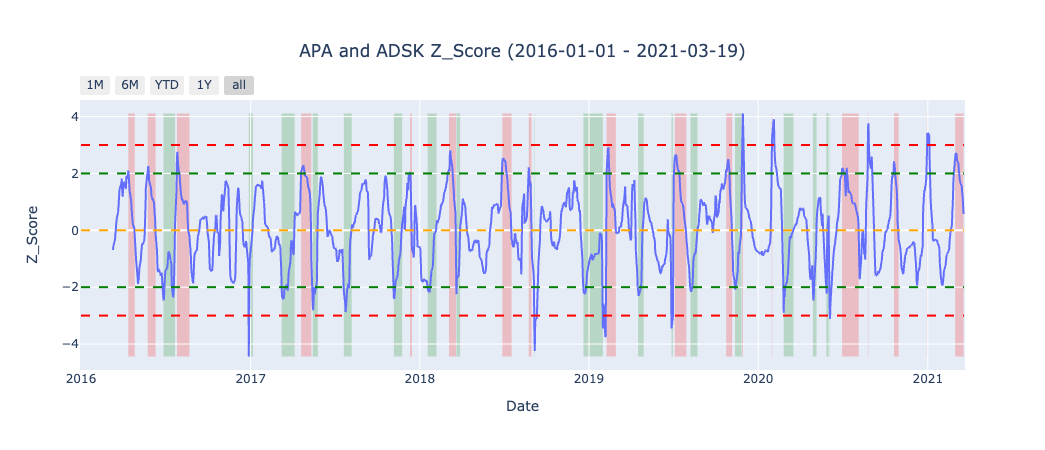

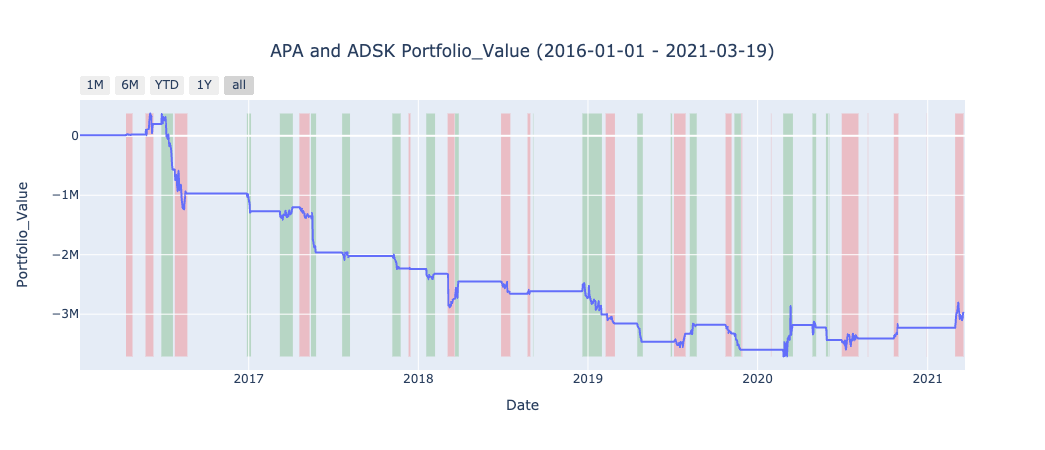

<ipython-input-10-a07491cc9670>:637: RuntimeWarning:

invalid value encountered in double_scalars



In [11]:
start = date(2016, 1, 1)
end = date.today()
name_1 = "APA"
name_2 = "ADSK"

model = statarb(name_1, name_2, start, end, beta_lookback=20, show_plot = True)
model.backtest_pair()

In [13]:
'''
get_spread
get_coint
get_signals
get_trades
get_portfolio
get_book
get_metrics
get_ts
'''
model.show_pair

<bound method statarb.show_pair of <__main__.statarb object at 0x7f9fb3cdc9d0>>

In [76]:
model.get_portfolio

,Returns,Cumulative_Returns,Portfolio_Value,Portfolio_Returns,Allocation,Max_Drawdown,In_Long,In_Short
Date,,,,,,,,
2016-01-04,0.000000,1.000000,1.000000e+04,NaN,10000,NaN,0.0,0.0
2016-01-05,0.000000,1.000000,1.000000e+04,0.000000,10000,NaN,0.0,0.0
2016-01-06,0.000000,1.000000,1.000000e+04,0.000000,10000,NaN,0.0,0.0
2016-01-07,0.000000,1.000000,1.000000e+04,0.000000,10000,NaN,0.0,0.0
2016-01-08,0.000000,1.000000,1.000000e+04,0.000000,10000,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...
2021-03-12,-0.022141,-363.062108,-3.630621e+06,-0.022141,10000,-1.001826,0.0,1.0
2021-03-15,0.018673,-369.841585,-3.698416e+06,0.018673,10000,-0.998460,0.0,1.0
2021-03-16,0.011014,-373.915183,-3.739152e+06,0.011014,10000,-0.999092,0.0,1.0


In [77]:
model.get_book[-8:]

,Date,Position_Type,Stock,Order_Type,Qty,Price,Profit/Loss,Cum_Sum_P_L
126,2020-10-29 00:00:00,Close Short,ADSK,Sell,38.0,242.839996,-649.800232,-15514.366894
127,2020-10-29 00:00:00,Close Short,APA,Buy,-14.0,8.190000,-12.180012,-15526.546906
128,2020-12-30 00:00:00,Short,ADSK,Buy,33.0,299.410004,0.000000,-15526.546906
129,2020-12-30 00:00:00,Short,APA,Sell,-2.0,14.570000,0.000000,-15526.546906
130,2020-12-31 00:00:00,Close Short,ADSK,Sell,33.0,305.339996,195.689758,-15330.857147
131,2020-12-31 00:00:00,Close Short,APA,Buy,-2.0,14.190000,-0.760000,-15331.617147
132,2021-02-26 00:00:00,Short,ADSK,Buy,36.0,276.000000,0.000000,-15331.617147
133,2021-02-26 00:00:00,Short,APA,Sell,1.0,19.730000,0.000000,-15331.617147


In [55]:
model.get_ts

,First_Day,Last_Day,Arb_Type,Arb_Leg_Long,Arb_Leg_Short
0,2016-08-08,2016-09-27,Short,ADSK,APA
1,2016-11-15,2016-12-09,Short,ADSK,APA
2,2017-01-24,2017-04-18,Short,ADSK,APA
3,2017-05-08,2017-07-06,Short,ADSK,APA
4,2017-08-24,2017-10-04,Short,ADSK,APA
...,...,...,...,...,...
30,2019-08-14,2019-09-04,Long,APA,ADSK
31,2019-10-07,2019-10-22,Long,APA,ADSK
32,2019-12-02,2019-12-03,Long,APA,ADSK
33,2020-03-06,2020-03-09,Long,APA,ADSK


In [56]:
model.get_metrics

,CAGR,Sharpe Ratio,Wins,P(Wins),Avg_Win_Return,Losses,P(Loss),Avg_Loss_Return,WL_Ratio
Date,,,,,,,,,
2016-01-04,2.034265,-0.006654,1297.0,0.990076,0.990076,13.0,0.009924,0.009924,99.769231
2016-01-05,2.034265,-0.006654,1297.0,0.990076,0.990076,13.0,0.009924,0.009924,99.769231
2016-01-06,2.034265,-0.006654,1297.0,0.990076,0.990076,13.0,0.009924,0.009924,99.769231
2016-01-07,2.034265,-0.006654,1297.0,0.990076,0.990076,13.0,0.009924,0.009924,99.769231
2016-01-08,2.034265,-0.006654,1297.0,0.990076,0.990076,13.0,0.009924,0.009924,99.769231
...,...,...,...,...,...,...,...,...,...
2021-03-11,2.034265,-0.006654,1297.0,0.990076,0.990076,13.0,0.009924,0.009924,99.769231
2021-03-12,2.034265,-0.006654,1297.0,0.990076,0.990076,13.0,0.009924,0.009924,99.769231
2021-03-15,2.034265,-0.006654,1297.0,0.990076,0.990076,13.0,0.009924,0.009924,99.769231
